In [4]:
import numpy as np
from astropy import units as u 
from astropy.io import fits
import matplotlib.pyplot as plt
import aplpy
from math import ceil
from astropy import stats 
from glob import glob
import matplotlib as mpl
from tqdm import tqdm
import colorcet
import multicolorfits as mcf
from PIL import Image
import os
import imageio
from spectral_cube import SpectralCube
%matplotlib inline 

import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append('/Users/abarnes/GitHub/misc/')
from data_cube_analysis import getdata

# plt.style.use('paper.mplstyle')

In [41]:
def plot_channel_maps_indv(channelmaps_hdu, fileappend='', outputdir='../figures/', 
                           start=-200, stop=200, step=20, 
                           vmin=None, vmax=None, 
                           l=0.77, b=-0.178, width=0.265, height=0.225, 
                           show_bubble=False, figsize=(5,5), dpi=150, 
                           velospread=5):
    """
    This function plots all the channel maps contained in a FITS HDU in a grid with a specified number of columns.
    It shows the velocity range in the upper right corner of each plot.

    Args:
    channelmaps_hdu (HDU): The FITS HDU containing the channel maps.
    start (int): The start of the velocity range for channel extraction. Default is -200 km/s.
    stop (int): The end of the velocity range for channel extraction. Default is 200 km/s.
    step (int): The velocity step size for channel extraction. Default is 20 km/s.

    Returns:
    None
    """
    # Determine the number of channels from the FITS HDU.
    channels = channelmaps_hdu.header['NAXIS3']
    
    # For each channel...
    n = channels-2
    for chan in tqdm(range(n)):
        
        # if chan!=0:
        #     continue

        # ...create a copy of the FITS HDU...
        channelmaps_hdu_ = channelmaps_hdu.copy()
        
        # ...replace the data in the HDU with the data for the current channel...
        channelmaps_hdu_.data = channelmaps_hdu_.data[chan]
        
        # Make RGB
        data = channelmaps_hdu.data

        if chan < velospread: 
            chans0 = list(np.arange(0, chan))
            if len(chans0)==0:
                chans0 = [chan]
        else: 
            chans0 = list(np.arange(chan-velospread, chan))

        if chan > n-velospread: 
            chans1 = list(np.arange(chan+1, n))
            if len(chans1)==0:
                chans1 = [chan]
        else: 
            chans1 = list(np.arange(chan+1, chan+1+velospread))

        # print(chans0, chan, chans1)

        # c0 = np.nanmax(data[chans0], axis=(0))
        # c1 = data[chan]
        # c2 = np.nanmax(data[chans1], axis=(0))

        c0 = data[np.nanmin(chans0)]
        c1 = data[chan]
        c2 = data[np.nanmax(chans1)]

        c0_grey = mcf.greyRGBize_image(c0, rescalefn='linear', min_max=[vmin, vmax]) 
        c1_grey = mcf.greyRGBize_image(c1, rescalefn='linear', min_max=[vmin, vmax]) 
        c2_grey = mcf.greyRGBize_image(c2, rescalefn='linear', min_max=[vmin, vmax])

        c0_r = mcf.colorize_image(c0_grey, '#FF0000', colorintype='hex')
        c1_g = mcf.colorize_image(c1_grey, '#00FF00', colorintype='hex') 
        c2_b = mcf.colorize_image(c2_grey, '#0000FF', colorintype='hex')

        # c0_r = mcf.colorize_image(c0_grey, '#994242', colorintype='hex')
        # c1_g = mcf.colorize_image(c1_grey, '#FFF9DB', colorintype='hex') 
        # c2_b = mcf.colorize_image(c2_grey, '#1773E9', colorintype='hex')

        comb_rgb = mcf.combine_multicolor([c0_r, c1_g, c2_b])
        comb_rgb_s = (comb_rgb*255).astype(np.uint8)

        # Save png
        alpha = Image.fromarray(comb_rgb_s[::-1], mode="RGB")
        alpha.save('tmp.jpeg', format='jpeg')

        # Make plot
        fig = plt.figure(figsize=figsize)

        gc = aplpy.FITSFigure(channelmaps_hdu_, subplot=(1, 1, 1), figure=fig)  
        gc.recenter(l, b, width=width, height=height)

        gc.show_rgb('tmp.jpeg')

        gc.show_contour(fits.PrimaryHDU(np.isnan(channelmaps_hdu_.data)*1, channelmaps_hdu_.header), levels=[1], linewidths=1, colors='white')

        # Remove ticks etc
        gc.axis_labels.hide()
        gc.tick_labels.hide()
        gc.ticks.set_color('black')
        gc.ticks.set_linewidth(2)
        gc.set_nan_color('none')

        # ...and display the velocity range in the upper right corner.
        step1 = start + (chan)*step
        # step2 = start + (chan)*step
        # velo_range = "%0.1f to %0.1f km/s" %(step1, step2)
        velo_range = "%0.1f km/s" %(step1)
        gc.add_label(0.05, 0.95, velo_range, relative=True, color='black', bbox=dict(facecolor='white', boxstyle='round', alpha=0.75), ha='left')

        if show_bubble:

            xcentre = 0.8041918903
            ycentre = -0.1838483592
            r_inner = 79/3600
            r_outer = 154/3600
            gc.show_ellipses(xcentre, ycentre, r_inner*2, r_inner*2, edgecolor='white', linestyles='dotted', linewidths=2, zorder=10., alpha=0.9)
            gc.show_ellipses(xcentre, ycentre, r_outer*2, r_outer*2, edgecolor='white', linestyles='dotted', linewidths=2, zorder=10., alpha=0.9)

        # Adjust the subplot layout to reduce space between subplots
        fig.tight_layout(h_pad=0, w_pad=-0.6)
        plt.subplots_adjust(wspace=-0.06, hspace=0)
        
        # Save the figure. 
        fig.savefig(outputdir+fileappend+'_%i.jpeg' %chan, bbox_inches='tight', dpi=dpi)
    
        plt.close('all')
        
        os.system('rm tmp.jpeg')

    return()

In [ ]:
inputfile = '/Users/abarnes/Dropbox/work/Smallprojects/aces/data/alma/12m7mtp_bubble/hnco43.TP_7M_12M_weighted_mosaic.rebin.K.kms.0.5kmschannel.galactic.fits'
print(inputfile)
hdu = fits.open(inputfile)[0]
cube = SpectralCube.read(hdu)
spectral_axis = cube.spectral_axis
spectral_axis_len = len(cube.spectral_axis)
print(cube)

# channelmaps_hdu = get_channel_maps(inputfile, 
#                                    start=-40, 
#                                    stop=130, 
#                                    step=2, 
#                                    method='max')

In [ ]:
# spectral_axis[:5-3]
# spectral_axis[5]
spectral_axis[6:5+3]

In [59]:
shift = 5
chans = np.arange(shift, spectral_axis_len-shift)

# for chan in chans:
for chan in [chans[0]]:

    print(chan-shift, chan, chan+shift)

    cube_neg = cube[chan-shift:chan,:,:]
    cube_cen = cube[chan,:,:]
    cube_pos = cube[chan+1:chan+shift,:,:]

    c0 = np.nanmax(cube_neg, axis=0)
    c1 = np.array(cube_cen)
    c2 = np.nanmax(cube_pos, axis=0)

    c0_grey = mcf.greyRGBize_image(c0, rescalefn='linear') 
    c1_grey = mcf.greyRGBize_image(c1, rescalefn='linear') 
    c2_grey = mcf.greyRGBize_image(c2, rescalefn='linear')

    c0_r = mcf.colorize_image(c0_grey, '#FF0000', colorintype='hex')
    c1_g = mcf.colorize_image(c1_grey, '#00FF00', colorintype='hex') 
    c2_b = mcf.colorize_image(c2_grey, '#0000FF', colorintype='hex')

0 5 10


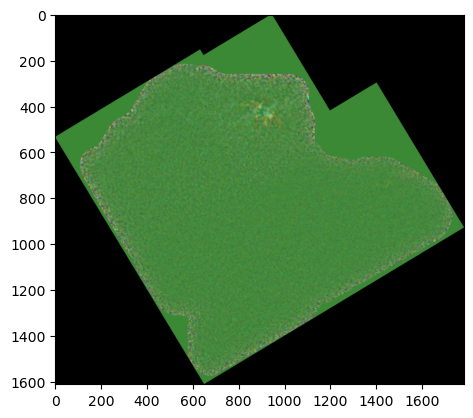

In [60]:
comb_rgb = mcf.combine_multicolor([c0_r, c1_g, c2_b])
comb_rgb_s = (comb_rgb*255).astype(np.uint8)

plt.imshow(comb_rgb_s)

In [57]:
np.array(cube_cen)

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)